# Determination of the refractive index

Considering the following experimental setup

<img src="exp1_setup_cropped.jpg" width="600">

which can be modeled as

<img src="exp1_model.png" width="400">

From the lab class notes we know that

\begin{equation}
x = t \sin(\theta)\left\lbrace 1 - \left[\frac{1 - \sin^2(\theta)}{n_{2}^2 -\sin^2(\theta) }\right]^\frac{1}{2}\right\rbrace.
\end{equation}

The raw data look something like (green is reference beam, black is for oil and pink is for water).

<img src="exp1_data.jpg" width="600">

In [1]:
# Notebook magic
%matplotlib notebook

# Import the packages that are needed
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats.distributions import chi2

# Use latex for labels
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex=True)

## Analysis

### Define the data
Define some variables containing the data aquired (remember to note down the unit of measure). 

In [44]:
# Data
delta_theta = 40/60 * np.pi/180    # [rad] Offset angle
theta_oil = np.pi/180 * np.array([-40/60, 5, 10, 15, 20, 25, 30, 35]) + delta_theta    # [rad]
theta_water = np.pi/180 * np.array([-40/60, 15, 20, 25, 30, 35]) + delta_theta   # [rad]

err_theta = np.pi/180 * 10/(60 * np.sqrt(12))    # [rad] Resolution error of protractor (10 minutes of arc)

x_oil = 1e-3 * np.array([0, 2, 4.5, 6.5, 9, 12, 15, 18])    # [m]
x_water = 1e-3 * np.array([0, 5, 7, 9.5, 12, 14])    # [m]
err_x = 1e-3 / np.sqrt(12)    # [m]

t = 0.074    # [m] internal width of the pool

Let's have a look at the data ...

<IPython.core.display.Javascript object>


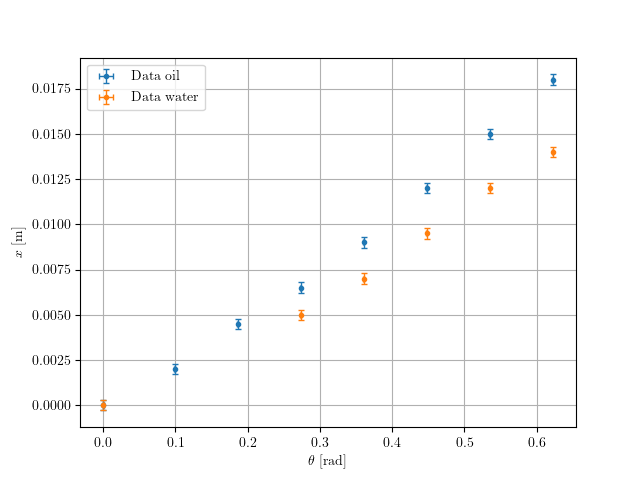

In [45]:
plt.figure()
plt.errorbar(theta_oil, x_oil, xerr=err_theta, yerr=err_x, marker='.', capsize=2, 
                   elinewidth=1, markeredgewidth=1, linestyle='', label='Data oil')
plt.errorbar(theta_water, x_water, xerr=err_theta, yerr=err_x, marker='.', capsize=2, 
                   elinewidth=1, markeredgewidth=1, linestyle='', label='Data water')

plt.grid()
plt.xlabel(r'$\theta\ [\mbox{rad}]$')
plt.ylabel(r'$x\ [\mbox{m}]$ ')
plt.legend()
plt.show()

### Fit
Let's use the function ``curve_fit`` to use a non-linear least squares algorithm to make the two fits.

The function ``curve_fit`` allows to use the y-uncertainties as the weights of the fit and it returns the *optimal parameters* and the *covariance matrix* (which is useful to determine the uncertainties on the fir paramters). 

First let's define the fit function ...

In [22]:
# Fit function
def my_fit_n(alpha, n):
    return t * np.sin(alpha) * (1 - np.sqrt((1 - np.sin(alpha)**2)/(n**2 - np.sin(alpha)**2)))

<IPython.core.display.Javascript object>


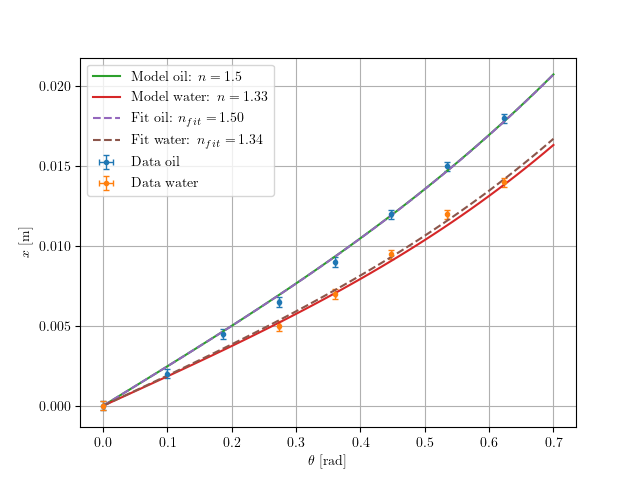

In [46]:
plt.figure()
plt.errorbar(theta_oil, x_oil, xerr=err_theta, yerr=err_x, marker='.', capsize=2, 
                   elinewidth=1, markeredgewidth=1, linestyle='', label='Data oil')
plt.errorbar(theta_water, x_water, xerr=err_theta, yerr=err_x, marker='.', capsize=2, 
                   elinewidth=1, markeredgewidth=1, linestyle='', label='Data water')

# Define a reasonable x-axis for the fit
angles = np.linspace(0, 0.7)

plt.plot(angles, my_fit_n(angles, 1.5), label='Model oil: $n=1.5$')
plt.plot(angles, my_fit_n(angles, 1.33), label='Model water: $n=1.33$')

# Use non-linear least squares to fit a function, f, to data
# Oil
popt_oil, pcov_oil = curve_fit(my_fit_n, theta_oil, x_oil, sigma=err_x * np.ones(len(x_oil)), absolute_sigma=True)
# Water
popt_water, pcov_water = curve_fit(my_fit_n, theta_water, x_water, sigma=err_x * np.ones(len(x_water)), absolute_sigma=True)

plt.plot(angles, my_fit_n(angles, *popt_oil), linestyle='--', label=r'Fit oil: $n_{fit}=\,$%.2f' % popt_oil)
plt.plot(angles, my_fit_n(angles, *popt_water), linestyle='--', label='Fit water: $n_{fit}=\,$%.2f'% popt_water)

plt.grid()
plt.xlabel(r'$\theta\ [\mbox{rad}]$')
plt.ylabel(r'$x\ [\mbox{m}]$ ')
plt.legend()
plt.show()

## Results
Here we report the results. 

Under reasonable assumptions, the uncertainties on the fit paramters can be estimated as the square root of the diagonal elements of the covariance matrix $\mathbf{C}=\left[c_{ij}\right]$:

\begin{equation}
\sigma_i= \sqrt{c_{ii}}
\end{equation}

In [47]:
print('******************** RESULTS ********************')
print('The optimal parameters (with 68% confidence) are:')
print('Refractive index oil:   %f +/- %f' % (popt_oil, np.sqrt(pcov_oil)))
print('Refractive index water: %f +/- %f' % (popt_water, np.sqrt(pcov_water)))

******************** RESULTS ********************
The optimal parameters (with 68% confidence) are:
Refractive index oil:   1.499474 +/- 0.008395
Refractive index water: 1.342760 +/- 0.006557


### Chi-squared test
We perform quickly a chi-squared test to check if our fits make sense or not ...

In [48]:
# Function that computes the reduced chi-square of my data
def chi2test(x_data, y_data, exp_err, fit_func, p_opt, false_alarm):
    # DOF is equal to the number of data points minus the number of parameters of the fit
    DOF = len(x_data) - len(p_opt)
    red_chi2 = np.sum((y_data - fit_func(x_data, *p_opt))**2 / exp_err **2) / DOF
    
    # Compare reduced chi-square values with the acceptable interval
    low_limit = chi2.ppf(false_alarm/2, df=DOF) / DOF
    up_limit = chi2.ppf(1 - false_alarm/2, df=DOF) / DOF
    
    print('***************** CHI-SQUARED TEST *****************')
    
    if red_chi2 <= up_limit and red_chi2 >= low_limit:
        print('PASSED!')
    else: 
        print('FAILED!')
    
    print('The reduced chi-square of the data is %f' % red_chi2)
    print('The acceptation interval with %.0f%% - confidence is: [%f, %f]\n' % ((1-false_alarm)*100, low_limit, up_limit))
    return red_chi2

red_chi2_oil = chi2test(theta_oil, x_oil, err_x, my_fit_n, popt_oil, 0.05)
red_chi2_water = chi2test(theta_water, x_water, err_x, my_fit_n, popt_water, 0.05)

***************** CHI-SQUARED TEST *****************
PASSED!
The reduced chi-square of the data is 1.152352
The acceptation interval with 95% - confidence is: [0.241410, 2.287538]

***************** CHI-SQUARED TEST *****************
PASSED!
The reduced chi-square of the data is 0.972747
The acceptation interval with 95% - confidence is: [0.166242, 2.566500]



### Conclusions
The idex of refraction found for the oil $n_{oil} = 1.52 \pm 0.02$ is consistent with the typical values found in literature (ranging from $1.4$ to $1.6$). 

The idex of refraction found for water $n_{\tiny \mbox{H}_2\mbox{O}} = 1.36 \pm 0.01$ is barely consistent (within $3\sigma$) with the nominal value $1.33$.